In [ ]:
library(tidyverse)
library(readxl)
library(reshape2)
library(Seurat)
library(cowplot)
library(viridis)
library(qs2)
library(future)
library(clustree)

In [2]:
theme_set(theme_cowplot())

#color scheme
use_colors <- c(
  Tumor = "brown2",
  Normal = "deepskyblue2",
  G1 = "#46ACC8",
  G2M = "#E58601",
  S = "#B40F20",
  Epithelial = "seagreen",
  Immune = "darkgoldenrod2",
  Stromal = "steelblue",
  p018 = "#E2D200",
  p019 = "#46ACC8",
  p023 = "#E58601",
  p024 = "#B40F20",
  p027 = "#0B775E",
  p028 = "#E1BD6D",
  p029 = "#35274A",
  p030 = "#F2300F",
  p031 = "#7294D4",
  p032 = "#5B1A18",
  p033 = "#9C964A",
  p034 = "#FD6467")

# Load data

In [3]:
epi <- qs_read("seurat_objects/epi.qs2")
imm <- qs_read("seurat_objects/imm.qs2")
str <- qs_read("seurat_objects/str.qs2")

# Rerun PCA, reclustering

In [4]:
plan("multisession", workers =5)
options(future.globals.maxSize = 15*1024^3) # 每个线程分配 10 GB 运行内存

## epi subclustering

In [ ]:
epi <- RunPCA(epi, verbose = FALSE)
ElbowPlot(epi,  ndims = 50)

#for (i in c(10, 15, 20, 25)){
#  umaptest <- RunUMAP(epi, dims = 1:i, verbose = F)
#  print(DimPlot(umaptest, reduction = "umap", group.by = "patient_id", split.by = "tissue_type") + labs(title = paste0(i, "dimensions")))
#  remove(umaptest)
#}

epi <- RunUMAP(epi, dims = 1:20, verbose = FALSE)
epi <- FindNeighbors(epi, dims = 1:20, verbose = FALSE)
for (i in c(0.1, 0.2, 0.3, 0.4, 0.5, 1, 2)) {
  epi <- FindClusters(epi, resolution = i, verbose = FALSE)
  #print(DimPlot(epi, reduction = "umap", label = T) + labs(title = paste0("resolution: ", i)))
}

Idents(epi) <- epi@meta.data$SCT_snn_res.1

## immune sublustering

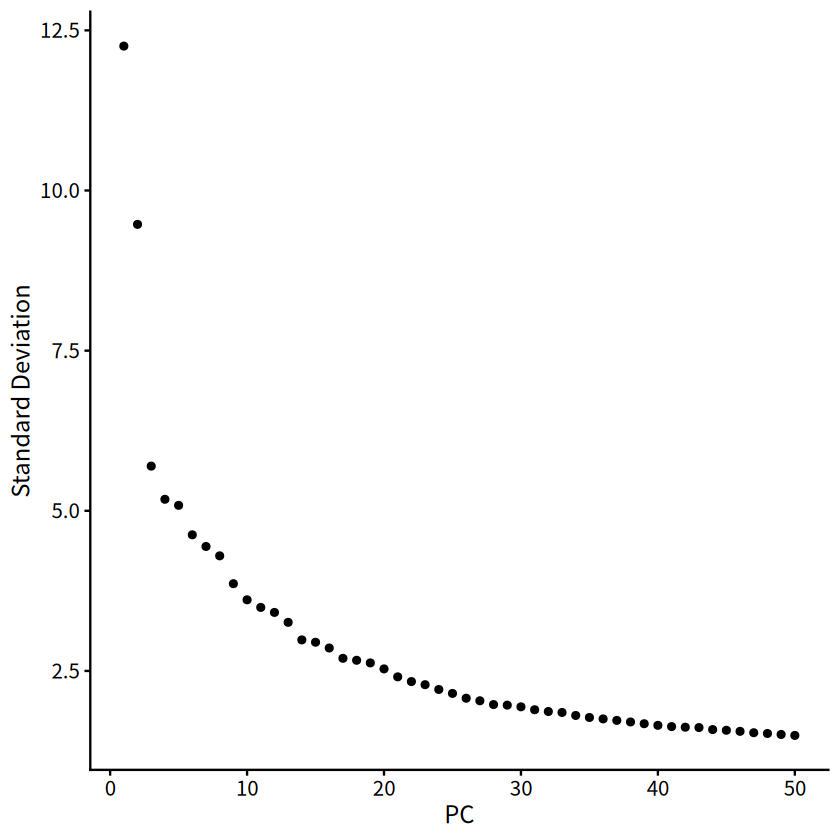

In [6]:
imm <- RunPCA(imm, verbose = FALSE)
ElbowPlot(imm,  ndims = 50)

#for (i in c(10, 15, 20, 25)){
#  umaptest <- RunUMAP(imm, dims = 1:i, verbose = F)
#  print(DimPlot(umaptest, reduction = "umap", group.by = "patient_id", split.by = "tissue_type") + labs(title = paste0(i, " dimensions")))
#  remove(umaptest)
#}

imm <- RunUMAP(imm, dims = 1:20, verbose = FALSE)
imm <- FindNeighbors(imm, dims = 1:20, verbose = FALSE)
imm <- FindClusters(
  object = imm,
  resolution = c(seq(0.1, 0.5, 0.1), 1, 2),
  verbose = FALSE
)

In [ ]:
# for (i in c(0.2, 0.3, 0.4, 0.5, 1, 2)) {
#   print(DimPlot(imm, reduction = "umap") + labs(title = paste0("resolution: ", i)))
# }

clustree(imm@meta.data, prefix = "SCT_snn_res.") #   RNA_snn_res.
# str(seu_obj@meta.data) 
ggsave("../output/annotation/immClusterTree.png",dpi = 300, width = 10, height = 6)

In [70]:
Idents(imm) <- imm@meta.data$SCT_snn_res.0.2

## stromal sublustering

In [ ]:
str <- RunPCA(str, verbose = FALSE)
ElbowPlot(str, ndims = 50)

#for (i in c(5, 10, 15, 20, 25, 30)){
#  umaptest <- RunUMAP(str, dims = 1:i, verbose = F)
#  print(DimPlot(umaptest, reduction = "umap", group.by = "patient_id", split.by = "tissue_type") + labs(title = paste0(i, " dimensions")))
#  print(DimPlot(umaptest, reduction = "umap", group.by = "tissue_type") + labs(title = paste0(i, " dimensions")))
#  remove(umaptest)
#}

str <- RunUMAP(str, dims = 1:20, verbose = FALSE)
str <- FindNeighbors(str, dims = 1:20, verbose = FALSE)
for (i in c(0.1, 0.2, 0.3, 0.4, 0.5, 1, 2)) {
  str <- FindClusters(str, resolution = i, verbose = FALSE)
  # print(DimPlot(str, reduction = "umap") + labs(title = paste0("resolution: ", i)))
}

Idents(str) <- str@meta.data$SCT_snn_res.1

In [9]:
qs_save(imm, "seurat_objects/imm2.qs2")
qs_save(str, "seurat_objects/str2.qs2")
qs_save(epi, "seurat_objects/epi2.qs2")

In [2]:
imm = qs_read("seurat_objects/imm2.qs2")

# Define normal and tumor cell clusters

In [ ]:
DimPlot(epi, group.by = "SCT_snn_res.1", label = T, repel = T, split.by = "tissue_type")
ggsave("../results/SuppFig3A.png", path = "../results", width = 30, height = 15, units = "cm", bg = "white")

In [11]:
### compare proportion of cells in a cluster to all epithelial cells for tumor and normal separately, clusters overrepresented in normal samples are supposed to be cell of normal lung parenchyma, all other clusters are supposed to be tumor cells

epi_clusters <- FetchData(epi, vars = c("SCT_snn_res.1", "tissue_type"))

count_tumor <- epi_clusters %>% filter(tissue_type == "Tumor") %>% count() %>% as.numeric()
count_normal <- epi_clusters %>% filter(tissue_type == "Normal") %>% count() %>% as.numeric()

epi_counts <- epi_clusters %>% group_by(tissue_type) %>% count(SCT_snn_res.1)
proportion_tumor <- epi_counts %>% filter(tissue_type == "Tumor") %>% mutate(proportion = n/count_tumor)
proportion_normal <- epi_counts %>% filter(tissue_type == "Normal") %>% mutate(proportion = n/count_normal)

proportion_epi <- full_join(proportion_normal, proportion_tumor, by = "SCT_snn_res.1") %>% 
  mutate(proportion.x = ifelse(is.na(proportion.x), 0,  proportion.x)) %>%  
  mutate(proportion.y = ifelse(is.na(proportion.y), 0,  proportion.y)) %>%
  mutate(tissue_type.x = "Normal") %>%
  mutate(tissue_type.y = "Tumor") %>%
  mutate(cluster_type = ifelse(proportion.x > proportion.y, "Normal", "Tumor"))

cluster_type_data <- left_join(x = epi_clusters, y = proportion_epi, by = "SCT_snn_res.1")
rownames(cluster_type_data) <- rownames(epi_clusters)

epi <- AddMetaData(epi, select(cluster_type_data, cluster_type))

## Bar plot for figure 2

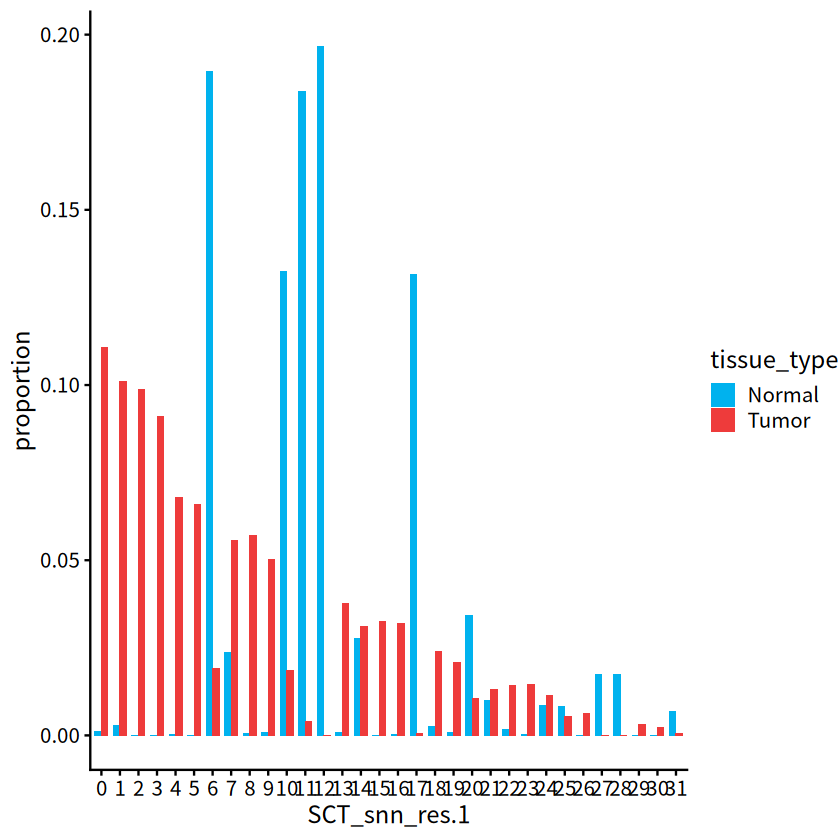

In [12]:
n1 <- select(proportion_epi, c(tissue_type.x, SCT_snn_res.1, proportion.x)) %>%
  mutate(tissue_type = tissue_type.x) %>% 
  mutate(proportion = proportion.x) %>%
  mutate(tissue_type.x = NULL) %>%
  mutate(proportion.x = NULL)
t1 <- select(proportion_epi, c(tissue_type.y, SCT_snn_res.1, proportion.y)) %>%
  mutate(tissue_type = tissue_type.y) %>% 
  mutate(proportion = proportion.y) %>%
  mutate(tissue_type.y = NULL) %>%
  mutate(proportion.y = NULL)

proportion_epi2 <- rbind(n1, t1)

ggplot(proportion_epi2, aes(fill = tissue_type, y = proportion, x = SCT_snn_res.1)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.7) +
  scale_fill_manual(values = use_colors)

ggsave("SuppFig3B.png", path = "../results", width = 40, height = 20, units = "cm", bg = "white")

# Cell type scoring

作者正在进行单细胞RNA测序数据的细胞类型注释和验证分析，主要目的是通过整合多个已发表研究的标记基因集（如Habermann、Travaglini、Vieira Braga等）来准确鉴定细胞类型，并检测可能的细胞污染。

## my

使用 DotPlot 可视化这些基因在不同聚类簇（如 SCT_snn_res.0.5）中的表达模式，通过点的大小和颜色强度反映基因表达水平。

生成分面（split.by = "tissue_type"）的降维图（DimPlot），观察细胞簇在正常组织与肿瘤组织间的分布差异。

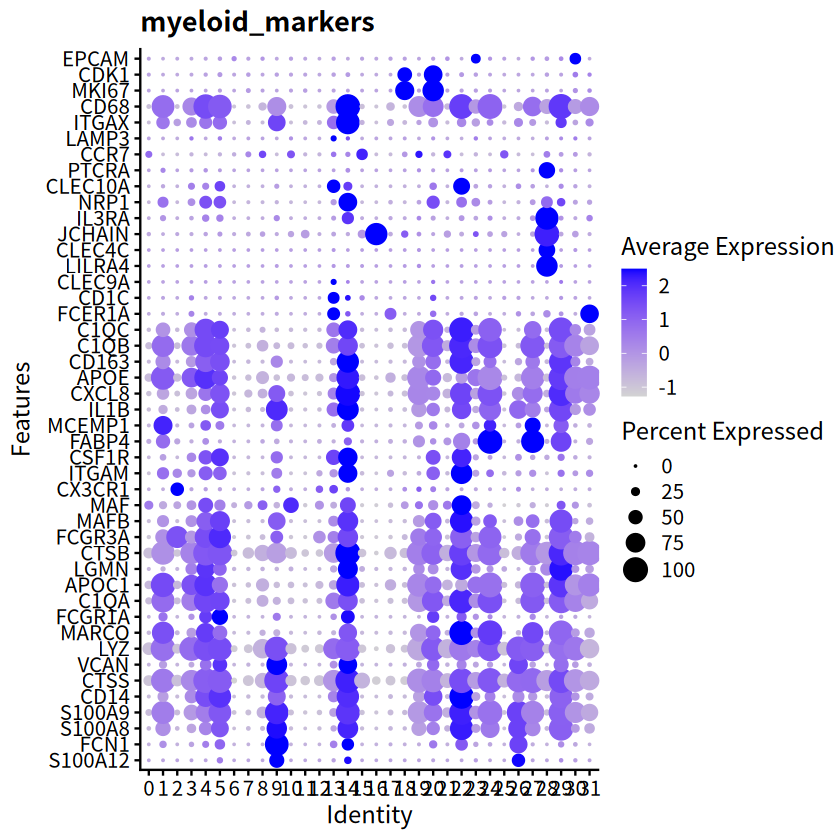

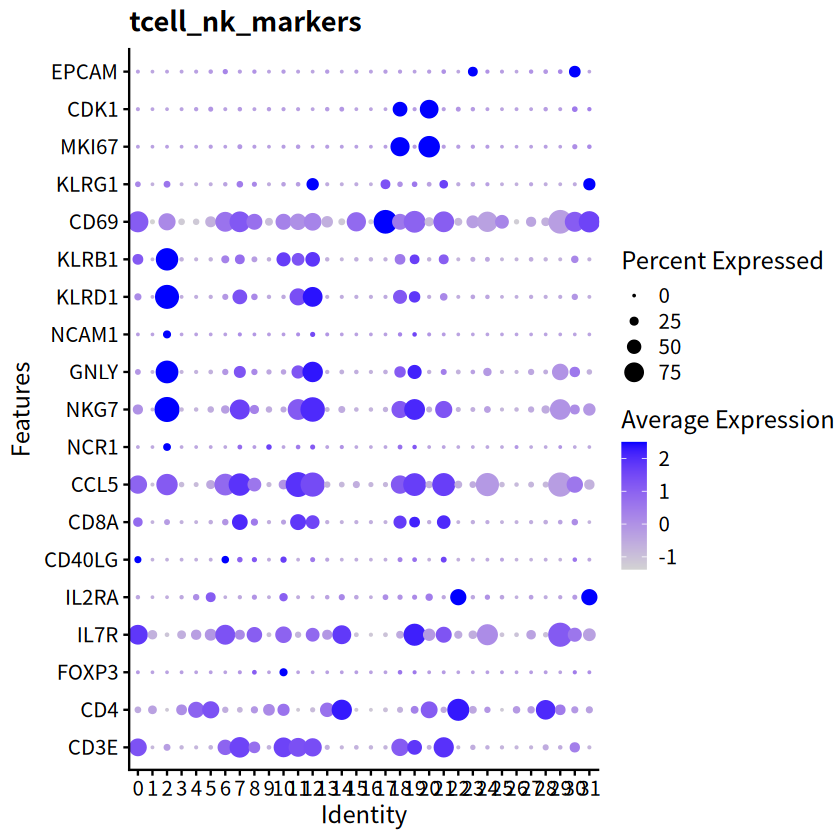

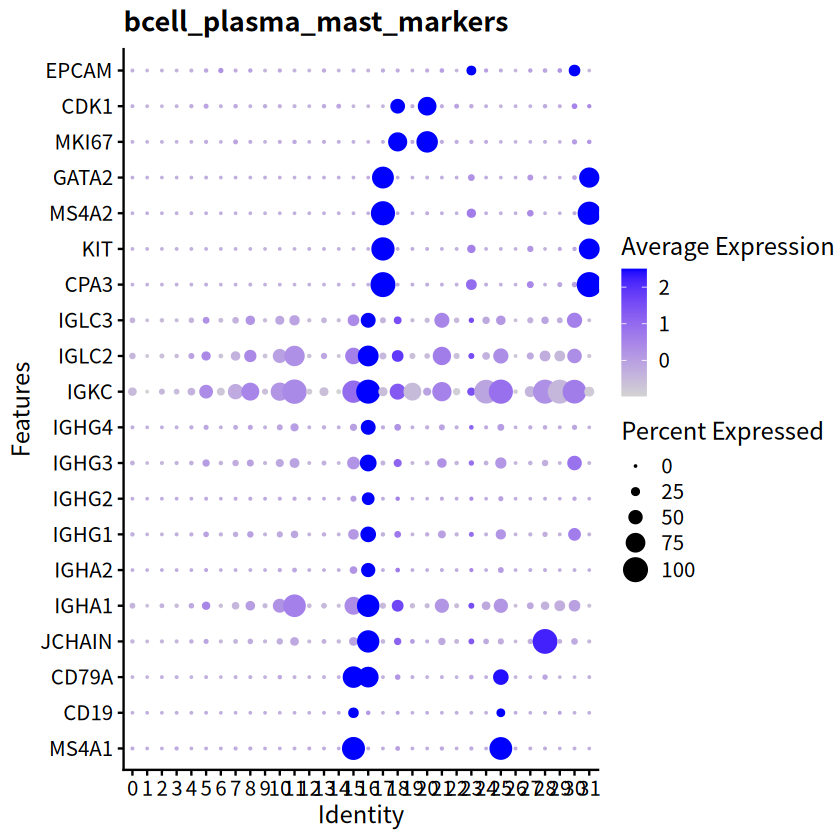

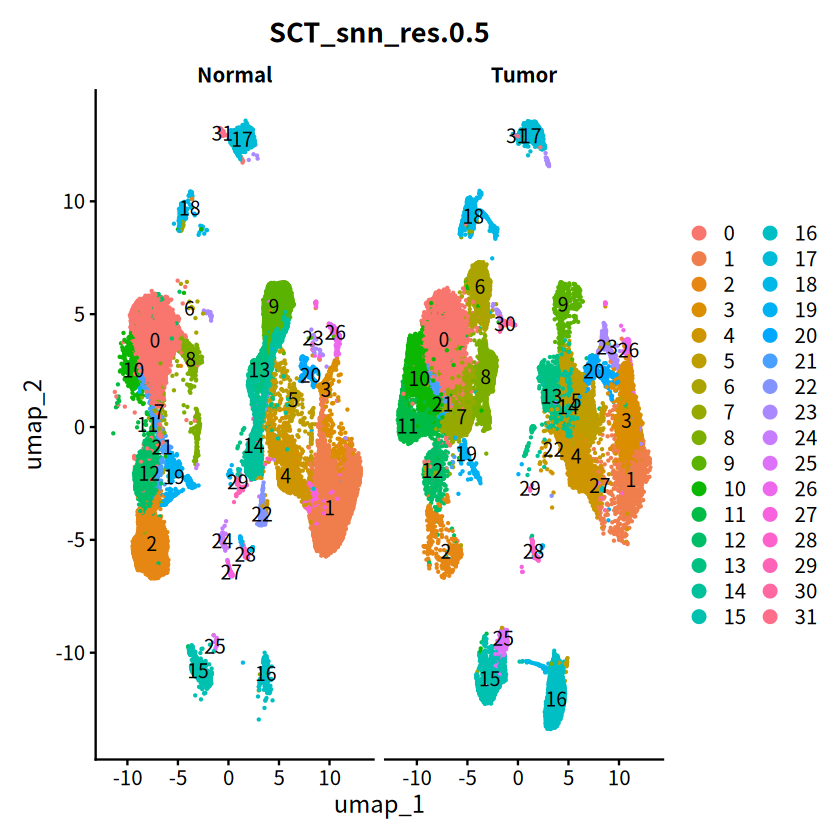

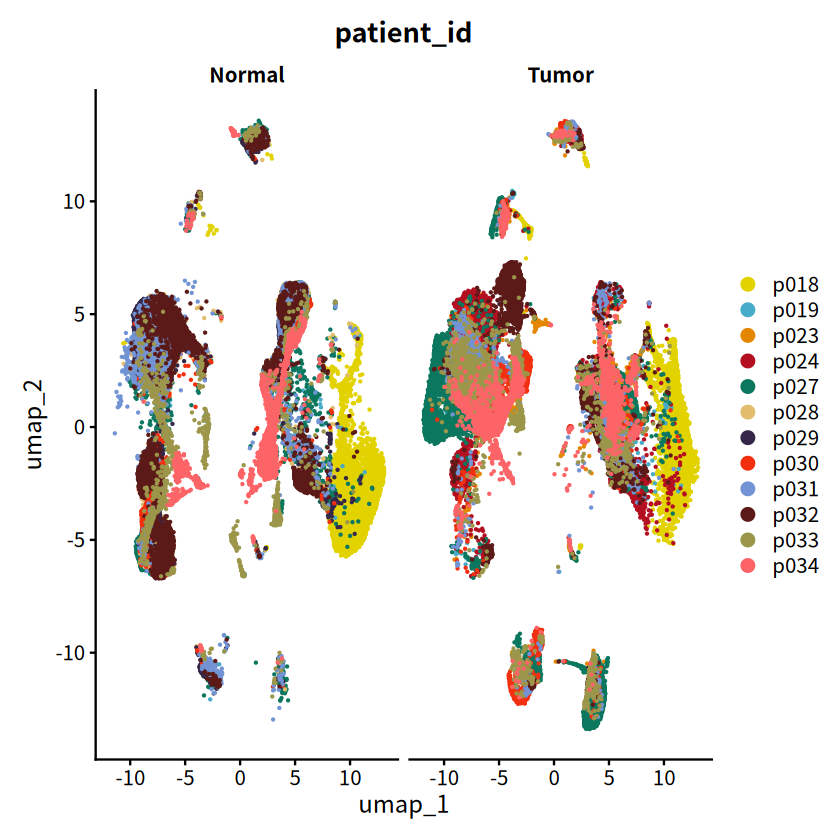

In [18]:
myeloid_markers <- c("S100A12", "FCN1", "S100A8", "S100A9", "CD14", "CTSS","VCAN", "LYZ", 
                     "MARCO", "FCGR1A", "C1QA", "APOC1", "LGMN", "CTSB", "FCGR3A", 
                     "MAFB", "MAF", "CX3CR1", "ITGAM", "CSF1R",
                     "FABP4", "MCEMP1", 
                     "IL1B", "CXCL8", 
                     "APOE", "CD163", "C1QB", "C1QC", 
                     "FCER1A", "CD1C", "CLEC9A", 
                     "LILRA4", "CLEC4C", "JCHAIN", "IL3RA", "NRP1", 
                     "CLEC10A", "PTCRA", "CCR7", "LAMP3", 
                     "ITGAX", "CD68", "MKI67", "CDK1", "EPCAM")

tcell_nk_markers <- c("CD3E", "CD4", "FOXP3", "IL7R", "IL2RA", "CD40LG", "CD8A", "CCL5", "NCR1", "NKG7", "GNLY", "NCAM1", "KLRD1", "KLRB1", "CD69", "KLRG1", "MKI67", "CDK1", "EPCAM")

bcell_plasma_mast_markers <- c("MS4A1", "CD19", "CD79A", "JCHAIN", "IGHA1", "IGHA2", "IGHG1", "IGHG2", "IGHG3", "IGHG4", "IGKC", "IGLC2", "IGLC3", "CPA3", "KIT", "MS4A2", "GATA2",  "MKI67", "CDK1", "EPCAM")

DotPlot(imm, features = myeloid_markers, group.by = "SCT_snn_res.0.5") + coord_flip() + labs(title = "myeloid_markers")
ggsave("DotPlot_myeloid_markers.png", path = "../output", width = 20, height = 20, units = "cm", bg = "white")

DotPlot(imm, features = tcell_nk_markers, group.by = "SCT_snn_res.0.5") + coord_flip()+ labs(title = "tcell_nk_markers")
ggsave("DotPlot_T_NK_markers.png", path = "../output", width = 20, height = 20, units = "cm", bg = "white")

DotPlot(imm, features = bcell_plasma_mast_markers, group.by = "SCT_snn_res.0.5") + coord_flip()+ labs(title = "bcell_plasma_mast_markers")
ggsave("DotPlot_B_Plasma_markers.png", path = "../output", width = 20, height = 20, units = "cm", bg = "white")

DimPlot(imm, group.by = "SCT_snn_res.0.5", label = T, split.by = "tissue_type")
ggsave("DimPlot_immune_clusters.png", path = "../output", width = 30, height = 15, units = "cm", bg = "white")

DimPlot(imm, group.by = "patient_id", split.by = "tissue_type", cols = use_colors)
ggsave("DimPlot_immune_patients.png", path = "../output", width = 30, height = 15, units = "cm", bg = "white")

## Habermann

Habermann et al.：
使用该研究的标记基因（如上皮 habermann_epi、免疫 habermann_imm、基质 habermann_oth）进一步验证细胞类型：

通过 SubsetData 筛选正常/肿瘤上皮细胞，用 DotPlot 检测免疫细胞污染的簇（如表达免疫标记 PTPRC 的上皮簇）。

In [ ]:
## Habermann et al.
#https://www.biorxiv.org/content/10.1101/753806v1
  
habermann_epi <- c("ABCA3", "SFTPB", "SFTPC", "AGER", "PDPN",  "KRT5", "TRP63", "NGFR", "SCGB1A1", "MUC5B", "KRT17", "FOXJ1", "TMEM190", "CAPS", "CHGA", "CALCA", "ASCL1", "PTPRC", "EPCAM")

habermann_imm <- c("CD3E", "CD4", "FOXP3", "IL7R", "IL2RA", "CD40LG", "CD8A", "CCL5", "NCR1", "KLRB1", "NKG7", "LYZ", "CD68", "ITGAX", "MARCO", "FCGR1A", "FCGR3A", "C1QA", "APOC1", "S100A12", "FCN1", "S100A9", "CD14", "FCER1A", "CD1C", "CD16", "CLEC9A", "LILRA4", "CLEC4C", "JCHAIN", "IGHG1", "IGLL5", "MS4A1", "CD19", "CD79A", "CPA3", "KIT", "MKI67", "CDK1", "EPCAM")

habermann_oth <- c("VWF", "PECAM1", "CCL21", "PROX1", "ACTA2", "MYH11", "PDGFRB", "WT1", "UPK3B", "LUM", "PDGFRA", "MYLK", "HAS1", "PLIN2", "FAP", "PTPRC", "EPCAM")

Warning message:
“The following requested variables were not found: TRP63”
Warning message:
“The following requested variables were not found: TRP63”


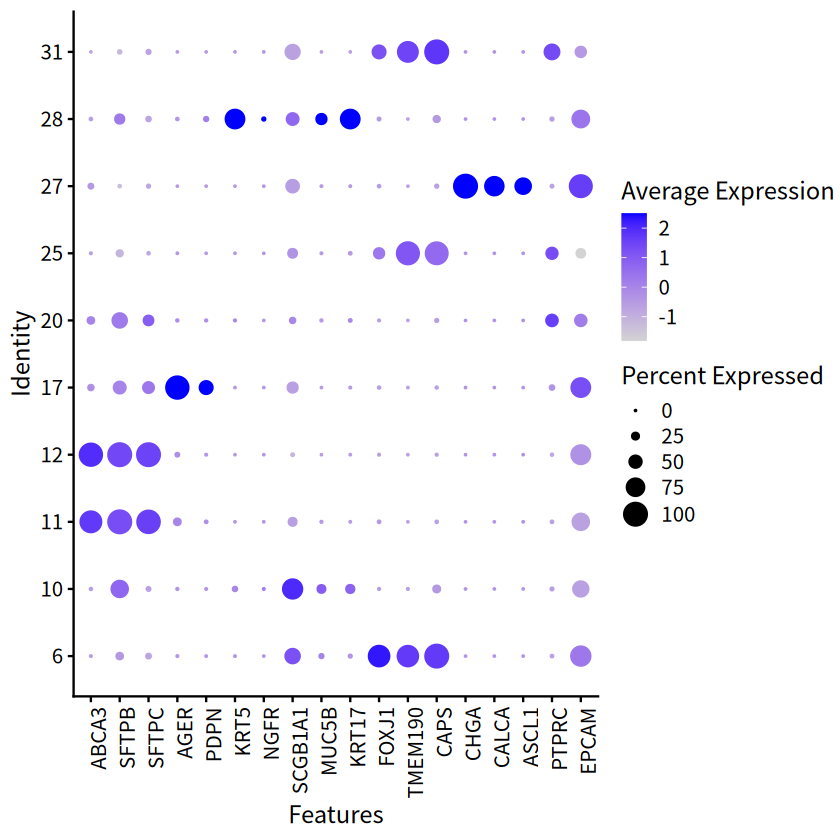

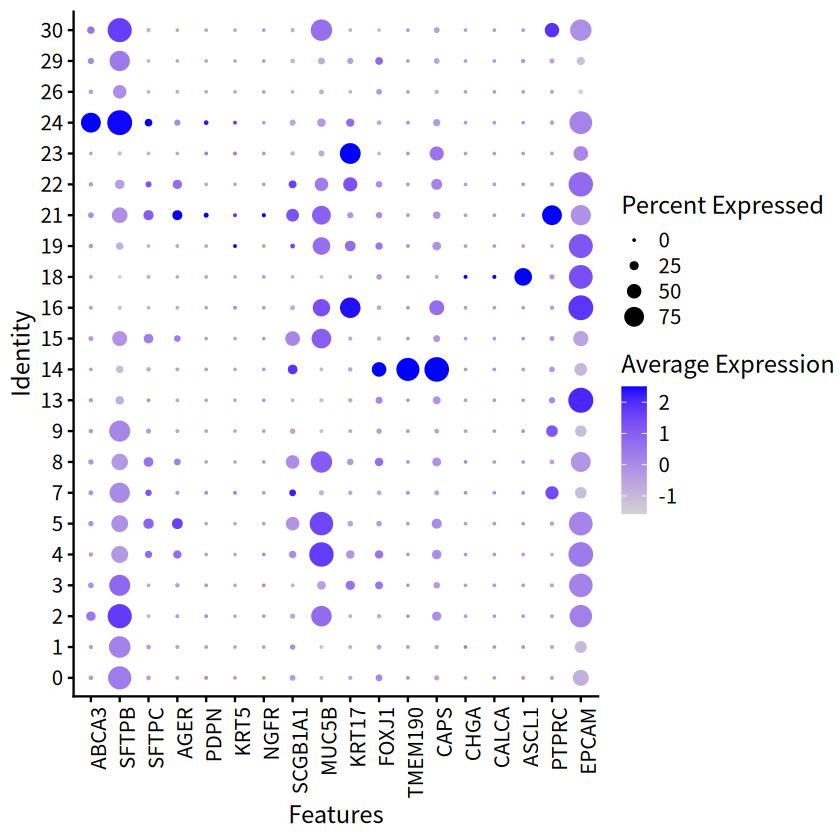

In [ ]:
### Epithelial genes according to Habermann et al.

### manual annotation of normal cell types & detection of immune cell contaminated clusters
DotPlot(subset(epi, cluster_type == "Normal"), features = habermann_epi, group.by = "SCT_snn_res.1") + theme(axis.text.x = element_text(angle = 90, hjust = 1))

### manual detection of immune cell contaminated clusters
DotPlot(subset(epi, cluster_type == "Tumor"), features = habermann_epi, group.by = "SCT_snn_res.1") + theme(axis.text.x = element_text(angle = 90, hjust = 1))

Warning message:
“The following requested variables were not found: CD16”


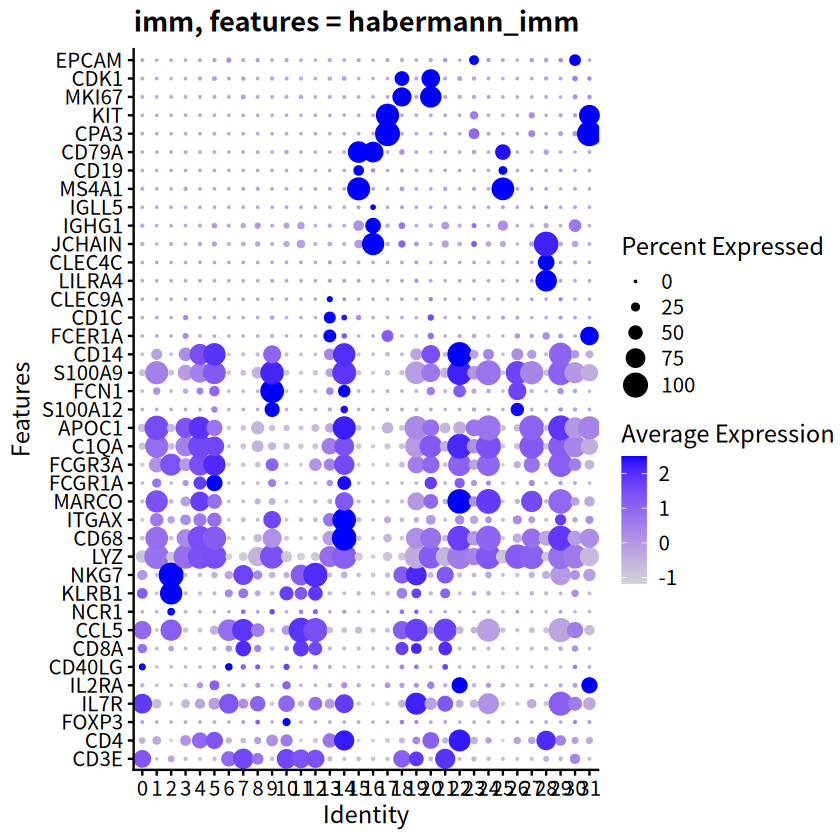

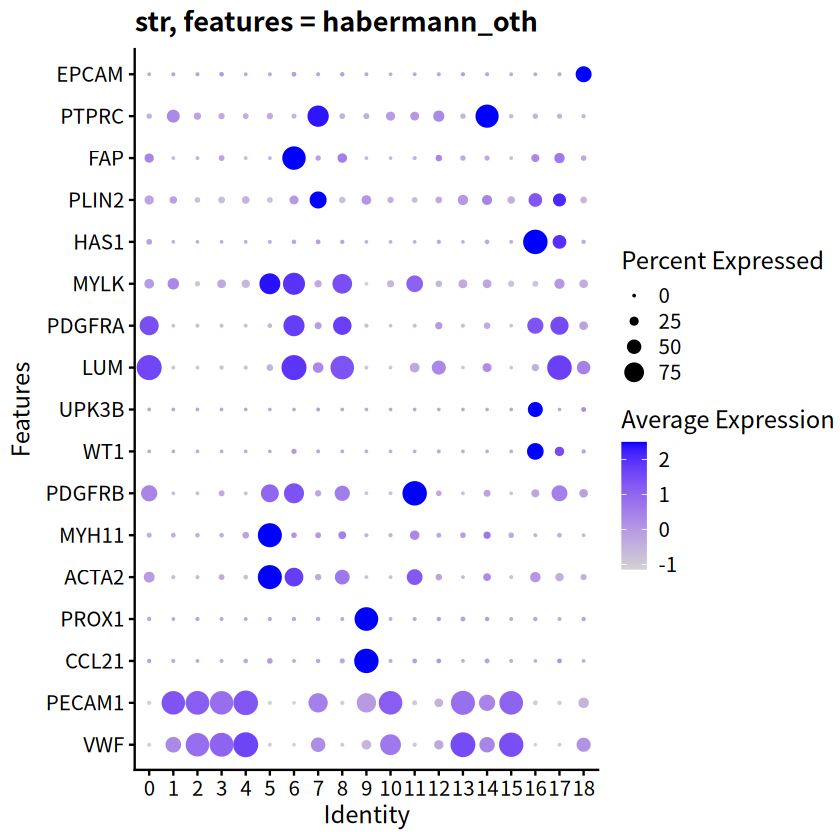

In [20]:
### Immune genes according to Habermann et al.

DotPlot(imm, features = habermann_imm, group.by = "SCT_snn_res.0.5") + 
  coord_flip() + 
  labs(title = "imm, features = habermann_imm")

#for (i in seq_along(habermann_imm)) {
#  plotlist <- list()
#  plotlist[1] <- FeaturePlot(imm, features = habermann_imm[i], sort.cell = T, combine = F)
#  plotlist[2] <- VlnPlot(imm, features = habermann_imm[i], pt.size = 0, combine = F)
#  print(CombinePlots(plots = plotlist))
#}

### Stromal genes according to Habermann et al.

DotPlot(str, features = habermann_oth, group.by = "SCT_snn_res.1") + 
  coord_flip()+
  labs(title = "str, features = habermann_oth")

#for (i in seq_along(habermann_oth)) {
#  plotlist <- list()
#  plotlist[1] <- FeaturePlot(str, features = habermann_oth[i], sort.cell = T, combine = F)
#  plotlist[2] <- VlnPlot(str, features = habermann_oth[i], pt.size = 0, combine = F)
#  print(CombinePlots(plots = plotlist, ncol = 3))
#}

我的课题需要的是免疫细胞极化评估，所以和他这里差别就比较大了，我需要的是注释极化状态，不过可以复现一下，看看 TCGA 怎么做的，有借鉴意义

Warning message:
“The following requested variables were not found: CD16”


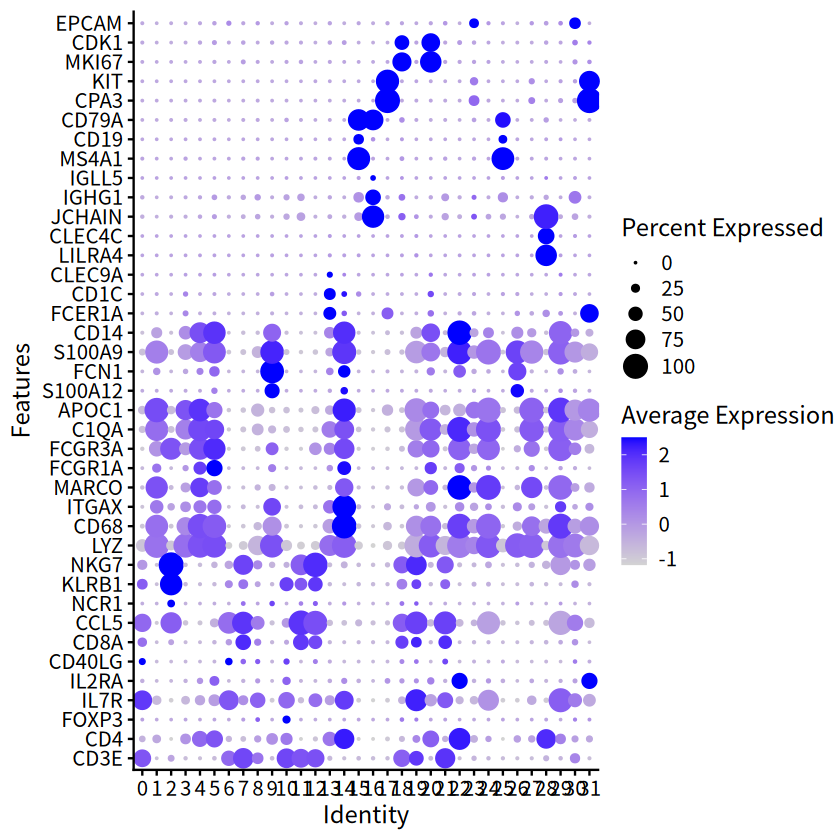

In [16]:
DotPlot(imm, features = habermann_imm, group.by = "SCT_snn_res.0.5") + coord_flip()

## Travaglini et al.

In [ ]:
#load marker gene lists

sheets <- paste0("Cluster ", c(1:58))
sheets <- sheets[-43]

signaturelist <- list()

for (i in seq_along(sheets)) {
  a <- read_excel("../data/data/media-3.xlsx", sheet = sheets[[i]])
  a <- filter(a, a$...2 > 0.7 & a$...4 < 0.3)
  signaturelist <- c(signaturelist,a[1])
  remove(a)
}

In [ ]:
#generate list with names of module scores in seurat object

names_of_modulescores <- c()
for (i in seq_along(signaturelist)){
  names_of_modulescores <- c(names_of_modulescores, paste0("T_", names(signaturelist[i]), i))
}

names_of_modulescores <- gsub(names_of_modulescores, pattern = " ", replacement = ".", fixed = TRUE)
names_of_modulescores <- gsub(names_of_modulescores, pattern = "+", replacement = ".", fixed = TRUE)
names_of_modulescores <- gsub(names_of_modulescores, pattern = "/", replacement = ".", fixed = TRUE)


#names_of_modulescores_unfiltered <- c()
#for (i in seq_along(signaturelist)){
#  names_of_modulescores_unfiltered <- c(names_of_modulescores_unfiltered, paste0(names(signaturelist[i]), "_unfiltered", i))
#}
#names_of_modulescores_unfiltered <- gsub(names_of_modulescores_unfiltered, pattern = " ", replacement = ".", fixed = TRUE)
#names_of_modulescores_unfiltered <- gsub(names_of_modulescores_unfiltered, pattern = "+", replacement = ".", fixed = TRUE)
#names_of_modulescores_unfiltered <- gsub(names_of_modulescores_unfiltered, pattern = "/", replacement = ".", fixed = TRUE)
#signature_list_updated <- list()
#for (i in seq_along(sheets)) {
#  signature_list_updated[[i]] <- checkGeneSymbols(signature_list[[i]])
#}

#calculate module scores for different subsets

epi <- AddModuleScore(object = epi, features = signaturelist, name = paste0("T_", names(signaturelist)))
imm <- AddModuleScore(object = imm, features = signaturelist, name = paste0("T_", names(signaturelist)))
str <- AddModuleScore(object = str, features = signaturelist, nbin = 12 , name = paste0("T_", names(signaturelist)))


In [ ]:
# 获取簇名
teichmann_epi <- unique(teichmann_signatures_epi$cluster)
teichmann_imm <- unique(teichmann_signatures_imm$cluster)

signaturelist2 <- list()

# 提取上皮簇的基因签名
for (i in seq_along(teichmann_epi)) {
  genes <- teichmann_signatures_epi %>% 
    filter(cluster == teichmann_epi[i], pct.2 < 0.3, avg_logFC > 0.7) %>% 
    pull(gene)
  
  if (length(genes) > 0) {  
    signaturelist2[[i]] <- genes
  }
}

# 提取免疫簇的基因签名
for (i in seq_along(teichmann_imm)) {
  genes <- teichmann_signatures_imm %>% 
    filter(cluster == teichmann_imm[i], pct.2 < 0.3, avg_logFC > 0.7) %>% 
    pull(gene)
  
  if (length(genes) > 0) {
    signaturelist2[[length(signaturelist2) + 1]] <- genes
  }
}

# 处理名称
names(signaturelist2) <- gsub(c(teichmann_epi, teichmann_imm)[1:length(signaturelist2)], 
                              pattern = "_", replacement = " ")

# 计算模块分数
epi <- AddModuleScore(epi, features = signaturelist2, name = paste0("VB_", names(signaturelist2)))
imm <- AddModuleScore(imm, features = signaturelist2, name = paste0("VB_", names(signaturelist2)))
str <- AddModuleScore(str, features = signaturelist2, nbin = 12, name = paste0("VB_", names(signaturelist2)))


# Curated cell type annotation and subsetting

In [ ]:
###epithelial

annotation_curated_epi <- read_excel("../data/curated_annotation/curated_annotation_epi.xlsx")
epi_anno <- epi
new_ids_epi <- annotation_curated_epi$cell_type_epi
names(new_ids_epi) <- levels(epi_anno)
epi_anno <- RenameIdents(epi_anno, new_ids_epi)
epi_anno@meta.data$cell_type_epi <- Idents(epi_anno)

epi_anno <- subset(epi_anno, subset = cell_type_epi != "Immune_contamination")
epi_anno <- ScaleData(epi_anno)

## imm

### garnett

In [4]:
library(monocle3)
library(garnett)

lung_classifier <- readRDS("../hsLung_20191017.RDS")

载入需要的程序包：Biobase

Warning message:
“程序包‘Biobase’是用R版本4.4.2 来建造的”
载入需要的程序包：BiocGenerics

Warning message:
“程序包‘BiocGenerics’是用R版本4.4.2 来建造的”

载入程序包：‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor


In [5]:
data <- GetAssayData(imm, assay = 'RNA', slot = 'counts') #str(pbmc@assays$RNA$data)
cell_metadata <- imm@meta.data
gene_annotation <- data.frame(gene_short_name = rownames(data))
rownames(gene_annotation) <- rownames(data)
cds <- new_cell_data_set(data,
                         cell_metadata = cell_metadata,
                         gene_metadata = gene_annotation)
#preprocess_cds函数相当于seurat中NormalizeData+ScaleData+RunPCA
cds <- preprocess_cds(cds, num_dim = 20)

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”


In [6]:
library(org.Hs.eg.db)
pData(cds)$garnett_cluster <- pData(cds)$seurat_clusters
cds <- classify_cells(cds,
                      lung_classifier, 
                      db = org.Hs.eg.db,
                      cluster_extend = TRUE,
                      cds_gene_id_type = "SYMBOL")

# 提取分类结果
cds.meta <- subset(pData(cds), select = c("cell_type", "cluster_ext_type")) %>% as.data.frame()
## 将结果返回给seurat对象
imm <- AddMetaData(imm, metadata = cds.meta)

载入需要的程序包：AnnotationDbi


载入程序包：‘AnnotationDbi’


The following object is masked from ‘package:dplyr’:

    select






This graph was created by an old(er) igraph version.
ℹ Call `igraph::upgrade_graph()` on it to use with the current igraph version.
For now we convert it on the fly...
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“The following genes used in the classifier are not present in the input CDS. Interpret with caution. ENSG00000248712”


In [64]:
imm@meta.data |> dplyr::select(`SCT_snn_res.0.2`, cell_type, cluster_ext_type) |> distinct(`SCT_snn_res.0.2`,cell_type,.keep_all = T)  |> filter(SCT_snn_res.0.2 == "20")

,SCT_snn_res.0.2,cell_type,cluster_ext_type
,<fct>,<chr>,<chr>
p019t_GTGTAACTCCAGTGCG-1,20,Macs/Monos/DCs,Macs/Monos/DCs
p027n_TCGTGGGAGACGAGCT-1,20,Unknown,Macs/Monos/DCs
p033n_TAGCACACAACTTCTT-1,20,Alveolar,Macs/Monos/DCs
p033n_TCTATCAAGTGGTTCT-1,20,Endothelial,Macs/Monos/DCs
p033n_TGAGCATCACAAAGCG-1,20,B cells,Macs/Monos/DCs
p033n_TGGATGTTCGCTGATA-1,20,Granulocytes,Macs/Monos/DCs
p033n_TTTACGTCAGCGAACA-1,20,Fibroblasts,Macs/Monos/DCs


In [12]:
table(imm@meta.data$`SCT_snn_res.0.2`)


    0     1     2     3     4     5     6     7     8     9    10    11    12 
14398 11083 10987  8094  6408  5201  4122  3557  3144  3114  2796  2553  1828 
   13    14    15    16    17    18    19    20 
 1293  1166   750   740   642   541   265   206 

### 手动

Warning message:
“The following requested variables were not found: CD20”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


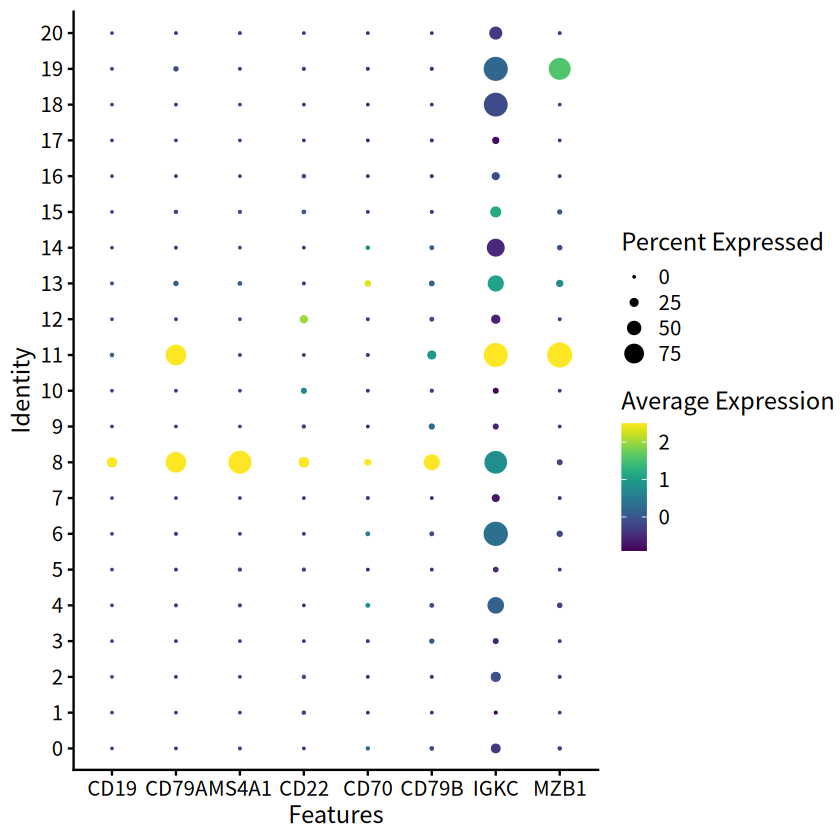

In [ ]:
Macrophage <- c("CST3","CD68","CD14","CCL18","CD163","CD11b","CD11c","CD80","CD86", "CD15", "CD33", "CD40", "CD63")
NK = c("NKp46", "FGFBP2", "FCG3RA", "CX3CR1","NCR1","NCAM", "KLRC1", "KLRC3")
B = c("CD19", "CD79A", "MS4A1","CD20", "CD22", "CD70", "CD79B","IGKC", "MZB1")
neutrophils= c("CST3", "LYZ","CSF3R","FCGR3B","Csf3r", "S100a8", "Cxcl3","CD10", "CD15", "CD17", "CD24", "CD35", "CD43", "CD66a")
pDC = c("Siglech", "Clec10a",  "Clec12a","CLEC4C", "CD85g", "ILT7", "CD123", "CD283", "TLR3", "CD303", "BDCA-2", "CD304", "BDCA-4", "CD370", "CLEC9A","CD287" ,"TLR7", "CD289", "TLR9", "E2-2", "IRF8", "IFNa", "IFNb")
cDCs= c("Xcr1", "Flt3", "Ccr7","CD1E")
CD4T = c("CD2", "CD3", "CD4", "CD5", "CD7", "CD25", "CD27", "CD28", "CD45RA", "CD45RO", "CD62L", "CD69", "CD127", "IL7Ra","CD134","OX40", "CD137", "4-1BB","CD152", "CTLA-4", "CD154", "CD40L", "CD272", "BTLA", "CD279" )
CD8T = c("CD2", "CD3", "CD5", "CD7", "CD8", "CD25", "CD27", "CD28")
gdT = c("TRDV2", "TRGV9")
Treg = c("FOXP3","CD25", "CD4", "CCR7","CD127")

DotPlot(imm, features = B , group.by = "SCT_snn_res.0.2") + 
  # coord_flip() + 
  scale_color_viridis()

In [ ]:
imm <- PrepSCTFindMarkers(imm)
Idents(imm) <- imm@meta.data$SCT_snn_res.0.2
marker = FindAllMarkers(imm, only.pos=T,logfc.threshold = 0.5)
write_csv(marker,file = "../output/ImmMarker_02.csv")

In [ ]:
marker = read_csv(file = "../output/ImmMarker_02.csv")
top10 <-  marker  %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)

In [126]:
table(imm@meta.data$`SCT_snn_res.0.2`)


    0     1     2     3     4     5     6     7     8     9    10    11    12 
14398 11083 10987  8094  6408  5201  4122  3557  3144  3114  2796  2553  1828 
   13    14    15    16    17    18    19    20 
 1293  1166   750   740   642   541   265   206 

Warning message in DoHeatmap(subset(imm, downsample = 200), features = top10$gene):
“The following features were omitted as they were not found in the scale.data slot for the SCT assay: GEMIN7-AS1, AC126755.2, ARHGAP28, TTC29, SSTR1, ACOT1, PMP2, ANO2, C8A, LINC00992, ARPP21, SLC9C2, AC007381.1, MIR4432HG, AC097375.1, CUX2, SHD, LRRC26, CLEC4C, WT1, BCHE, LINC02057, CFAP161, HHIPL1, AC103718.1, C4BPB, LGI2, ADAMTS2, PIMREG, KIF20A, IQGAP3, DEPDC1, PLK1, DIAPH3, CEP55, LINC02257, MAGEA3, KIF1A, PKHD1, LINC02474, DMRTA2, HS6ST2, CYP46A1, SLITRK5, RET, GPR15, VASH2, SCT, GREM2, AP000251.1, TMSB15A, C1QL1, HIST1H3F, HIST1H3B, SPC24, PBK, SPC25, KIF15, LINC02147, LINC00323, CMA1, AL662860.1, TPSD1, AL157895.1, IGHV3-53, IGKV2D-28, IGHV3-66, CLEC19A, GRTP1-AS1, OR8G1, LINC01471, TIMP4, OR8G5, SLC5A10, BPI, GPR20, AC110079.2, LINC00482, AC106712.1, SERPINB10, AC064805.1, C12orf74, HCG22, KLHL14, AL161781.2, COL19A1, CR2, EBF1, PAX5, SLC10A2, C4orf50, NTRK2, GNG4, COL22A1, AC084871.2, LINC0220

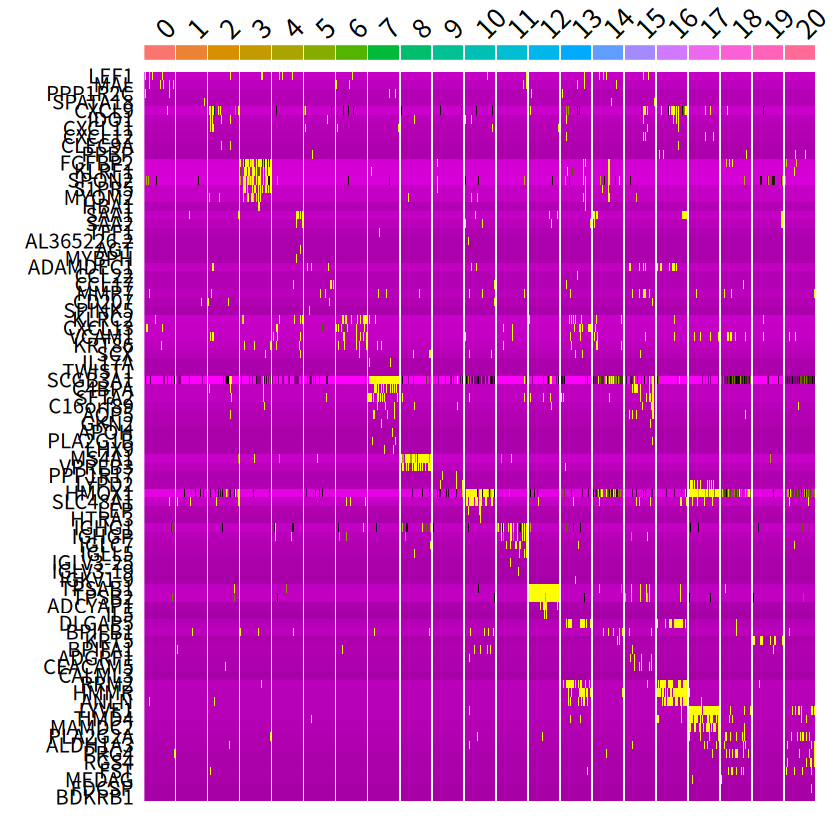

In [ ]:
DoHeatmap(subset(imm, downsample = 200), features = top10$gene)+ NoLegend()
ggsave("../output/DoHeatmap.png", dpi = 300, width = 10, height = 15)
# 结合热图、marker 基因，进行注释（多个 cluster可能属于一种细胞），把marker 对应的细胞进行记录，可训练 garneet模型，好处是可以自己定义细胞类型，但是可能会有没有考虑到的类型，这个时候结合已经训练好的分类器就很好了，两种策略结合

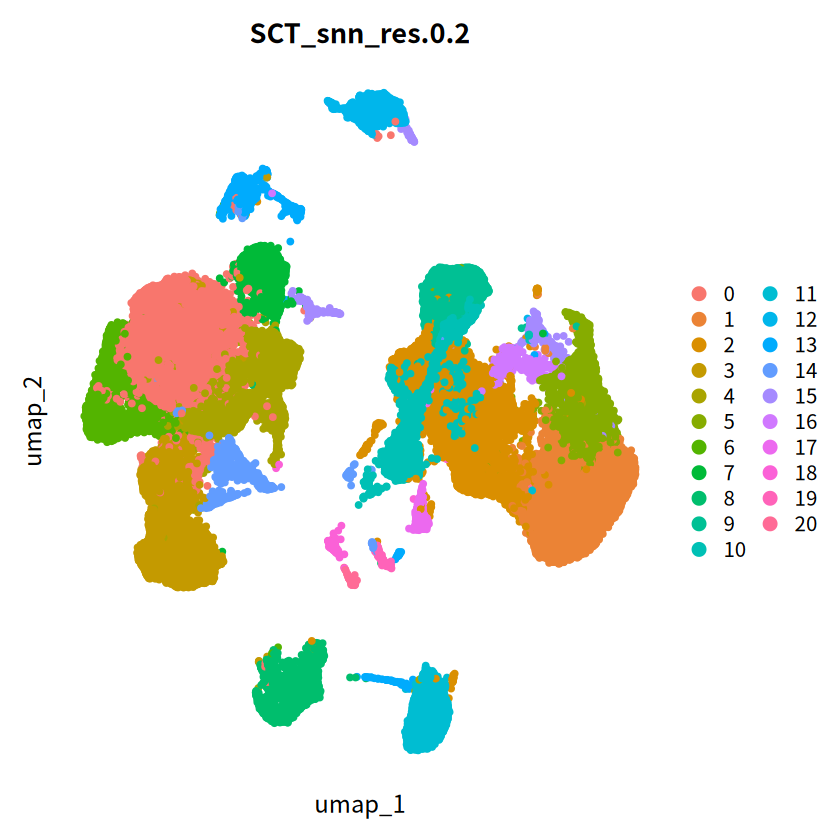

In [112]:
DimPlot(imm, reduction = "umap", group.by = "SCT_snn_res.0.2", pt.size=1)+theme(
  axis.line = element_blank(),
  axis.ticks = element_blank(),axis.text = element_blank()
)

In [72]:
###immune
annotation_curated_imm <- read_excel("../data/curated_annotation/curated_annotation_imm.xlsx", sheet = "my")
imm_anno <- imm
new_ids_imm <- annotation_curated_imm$cell_type_imm
names(new_ids_imm) <- levels(imm_anno)
imm_anno <- RenameIdents(imm_anno, new_ids_imm)
imm_anno@meta.data$cell_type_imm <- Idents(imm_anno)

imm_anno <- subset(imm_anno, subset = cell_type_imm != "Epithelial_contamination")
imm_anno <- ScaleData(imm_anno)

Centering and scaling data matrix



In [77]:
qs_save(imm_anno, "seurat_objects/imm_anno.qs2")

In [ ]:
###stromal

annotation_curated_str <- read_excel("../data/curated_annotation/curated_annotation_str.xlsx")
str_anno <- str
new_ids_str <- annotation_curated_str$cell_type_str
names(new_ids_str) <- levels(str_anno)
str_anno <- RenameIdents(str_anno, new_ids_str)
str_anno@meta.data$cell_type_str <- Idents(str_anno)

str_anno <- subset(str_anno, subset = cell_type_str != "Immune/Epithelial contamination")
str_anno <- ScaleData(str_anno)